In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm

In [2]:
region = df.Region(p1=(0, 0, 0), p2=(100e-9, 1e-9, 1e-9))
subregions = {
    'left': df.Region(p1=(0, 0, 0), p2=(1e-9, 1e-9, 1e-9)),
    'right': df.Region(p1=(99e-9, 0, 0), p2=(100e-9, 1e-9, 1e-9)),
    'center': df.Region(p1=(1e-9, 0, 0), p2=(99e-9, 1e-9, 1e-9)),
}
mesh = df.Mesh(region=region, cell=(1e-9, 1e-9, 1e-9), subregions=subregions)

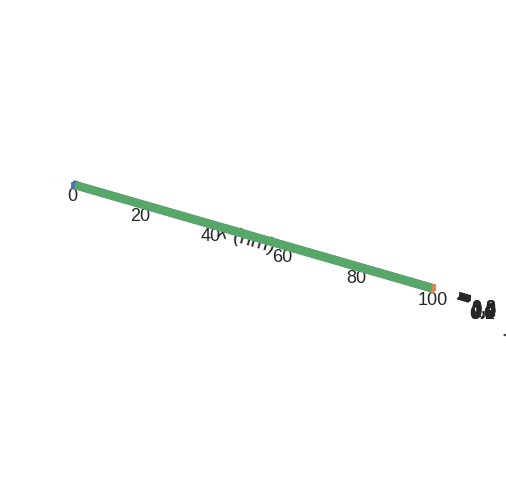

In [3]:
mesh.mpl.subregions(show_region=True)

In [4]:
import math
Ms = 3.84e5
A = 8.78e-12
D = 1.58e-3
Ld = 4*math.pi*(A/D)
Ld

6.983084430004653e-08

In [5]:
def m_init(p):
    x, y, z = p
    k = 2*math.pi/70e-9
    mx = math.cos(k*x)
    my = math.sin(k*x)
    return 0, mx, my

In [6]:
system = mm.System(name='toy_problem')

system.energy = (mm.Exchange(A=8.78e-12) 
                 + mm.DMI(D=D, crystalclass="T")
                # + mm.UniaxialAnisotropy(K=0.5e6, u=(1,0,0))
                # + mm.Zeeman(H=(0, 0, 0.2/mm.consts.mu0))
               # + mm.Demag()
                )
                 
system.dynamics = mm.Precession(gamma0=mm.consts.gamma0) + mm.Damping(alpha=1e-1)
m = {'left': (0,0,1), 'center': m_init, 'right':(0,0,1)}
system.m = df.Field(mesh, nvdim=3, value=m, norm=3.84e5, valid='norm')                

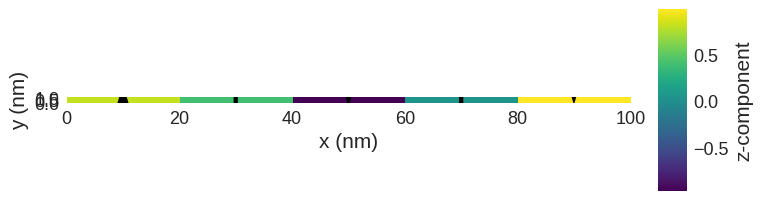

In [7]:
system.m.orientation.sel('z').resample(n=(5,1)).mpl()

In [8]:
md = oc.MinDriver()
md.drive(system, fixed_subregions=['left', 'right'])

Running OOMMF (ExeOOMMFRunner)[2024/10/29 16:57]... (0.5 s)


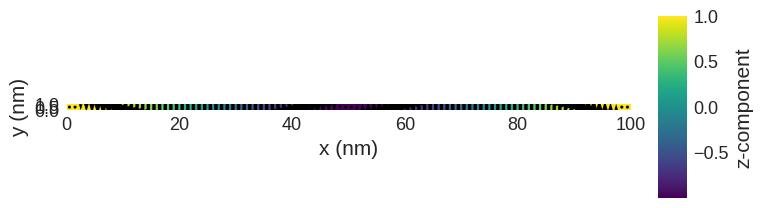

In [9]:
system.m.orientation.sel('z').mpl()

In [10]:
td = oc.TimeDriver()
td.drive(system, t=5e-9, n=1000, fixed_subregions=['left', 'right'])

Running OOMMF (ExeOOMMFRunner)[2024/10/29 16:57]... (23.2 s)


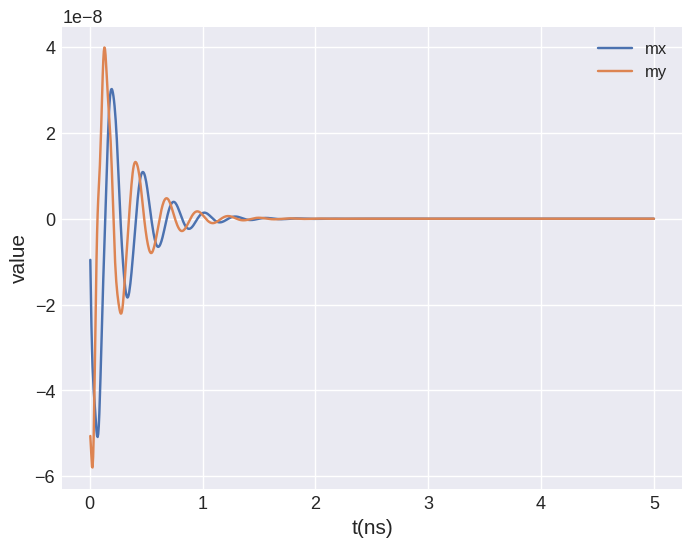

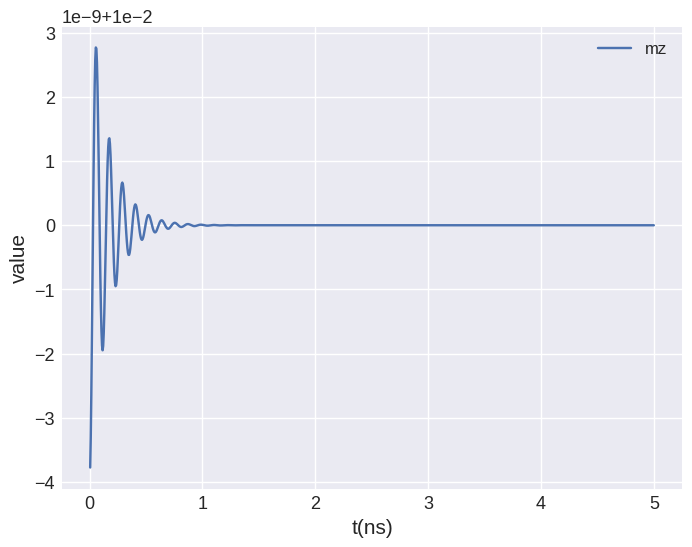

In [11]:
system.table.mpl(y=['mx', 'my'])
system.table.mpl(y=['mz'])

In [12]:
system.dynamics.damping.alpha = 2e-3

In [13]:

import math
def init_H(p):
    x, _, _ = p
    x0 = mesh.region.edges[0]/2
    k = 10/mesh.region.edges[0]
    return 0 , 0, math.sin(2*math.pi*k*(x-x0))/(2*math.pi*k*(x-x0))

H_field = df.Field(mesh=mesh, nvdim=3, value=init_H)

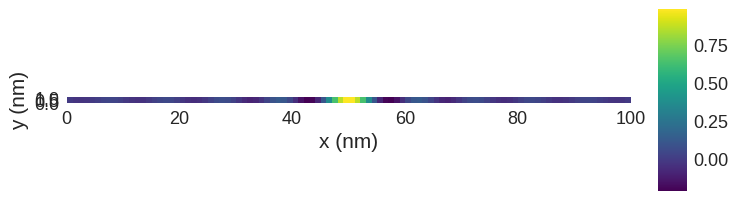

In [14]:
H_field.sel('z').z.mpl()

In [15]:
H_Sinc = mm.Zeeman(name="Sinc", H=160*H_field, func='sinc', f=1e11, t0=1e-9) # 
system.energy += H_Sinc
system.energy

Exchange(A=8.78e-12) + DMI(D=0.00158, crystalclass='T') + Zeeman(H=Field(Mesh(Region(pmin=[0.0, 0.0, 0.0], pmax=[1e-07, 1e-09, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), n=[100, 1, 1], subregions: (Region`left`(pmin=[0.0, 0.0, 0.0], pmax=[1e-09, 1e-09, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`right`(pmin=[9.9e-08, 0.0, 0.0], pmax=[1e-07, 1e-09, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']), Region`center`(pmin=[1e-09, 0.0, 0.0], pmax=[9.9e-08, 1e-09, 1e-09], dims=['x', 'y', 'z'], units=['m', 'm', 'm']))), nvdim=3, vdims: (x, y, z)), f=100000000000.0, t0=1e-09, func='sinc')

In [16]:
td = oc.TimeDriver()
td.drive(system, t=2e-9, n=1000, fixed_subregions=['left', 'right'])

Running OOMMF (ExeOOMMFRunner)[2024/10/29 16:57]... (20.1 s)


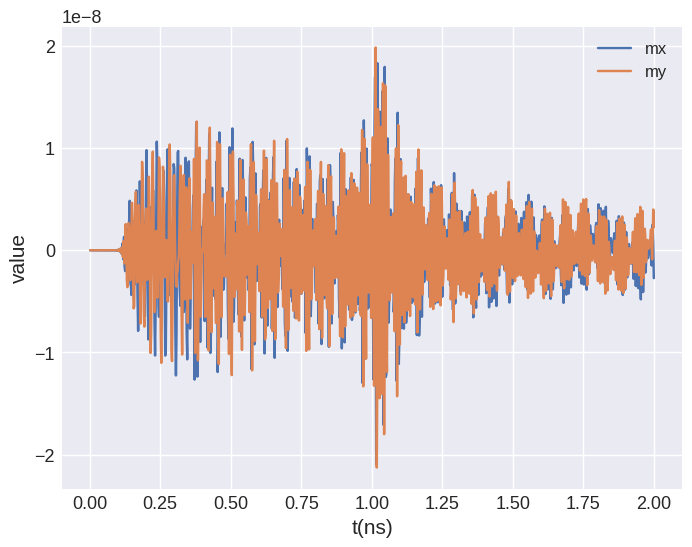

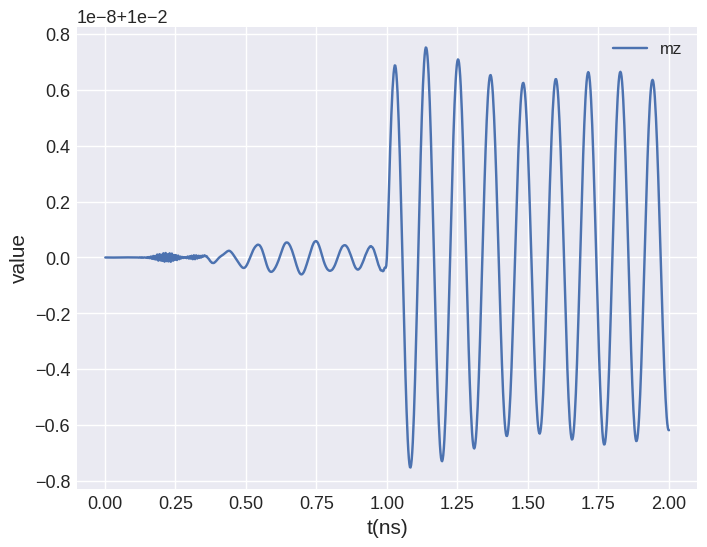

In [17]:
system.table.mpl(y=['mx', 'my'])
system.table.mpl(y=['mz'])

In [18]:
system.energy -= H_Sinc

In [19]:
system.energy

Exchange(A=8.78e-12) + DMI(D=0.00158, crystalclass='T')

In [20]:
sim_time = 10e-9  # Minimum frequency and resolution 0.01 GHz 
sampaling_rate = 400e9  # Hz Maximum frequency 100 GHz
n = sim_time * sampaling_rate
print(n)

4000.0


In [21]:
td = oc.TimeDriver()
td.drive(system, t=sim_time, n=int(n), n_threads=16, fixed_subregions=['left', 'right'])

Running OOMMF (ExeOOMMFRunner)[2024/10/29 16:58]... (151.8 s)


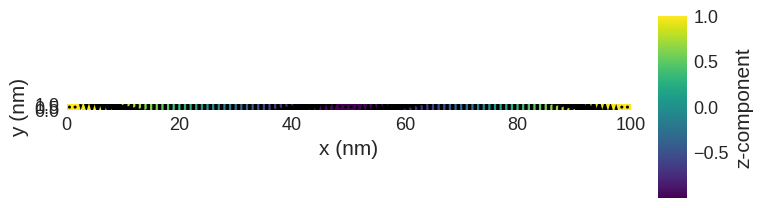

In [22]:
system.m.orientation.sel('z').mpl()

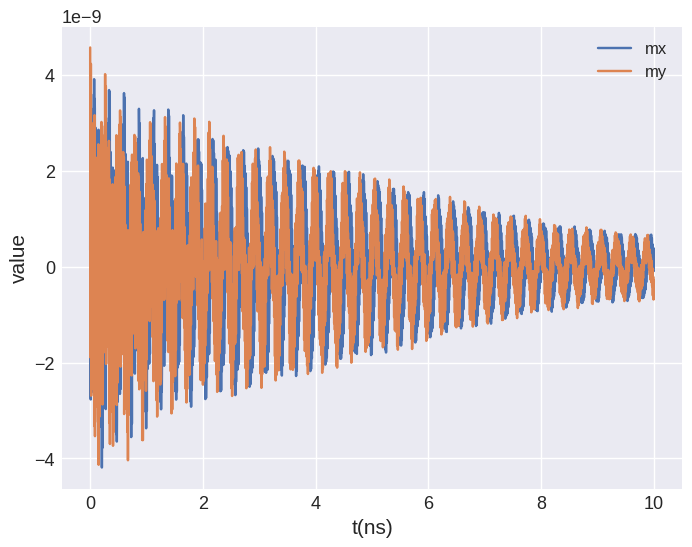

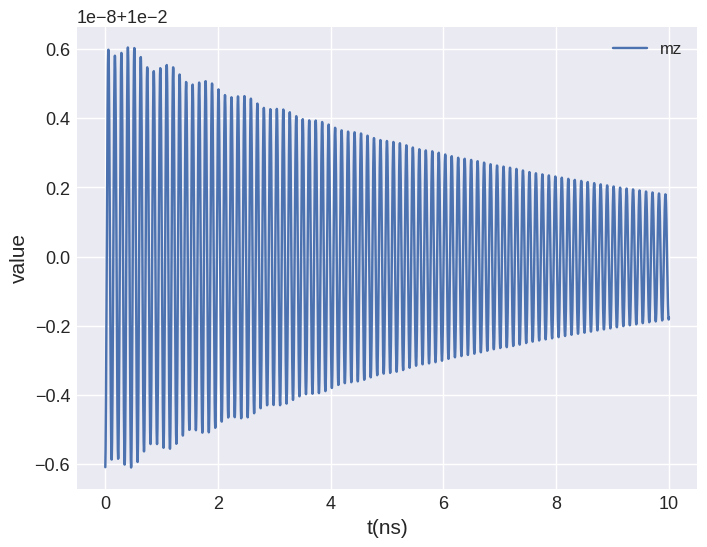

In [23]:
system.table.mpl(y=['mx', 'my'])
system.table.mpl(y=['mz'])

In [24]:
import micromagneticdata as mdata
data=mdata.Data(name='toy_problem')

In [25]:
from micromagneticdata.ringdown_analysis import RingdownAnalysis

In [26]:
processor = RingdownAnalysis(data[3], init_data=data[0])

In [27]:
processor.extract_mz_subregion('left')

array([1., 1., 1., ..., 1., 1., 1.])

In [28]:
frequency_both, magnitude_both = processor.spatially_averaged_psd()

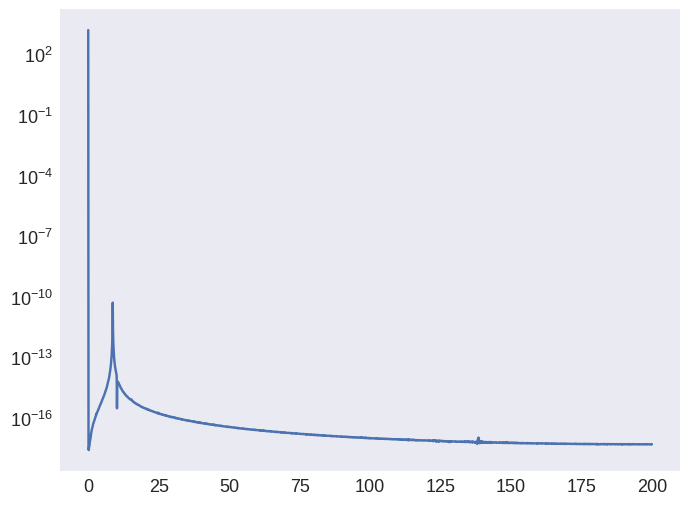

In [29]:
import matplotlib.pyplot as plt
plt.plot(frequency_both/1e9, magnitude_both)
plt.yscale('log')

In [30]:
processor.select_subregion('left')
processor.fft_analysis1('left')
left_power = processor.power_ave

In [31]:
processor.select_subregion('both')
processor.fft_analysis1('both')
both_power = processor.power_ave

In [32]:
processor.find_peaks(prominence=1e-10, axis=2)

In [33]:
peaks = processor.peaks
peaks

array([714, 752, 816])

In [34]:
processor.freq[peaks]/1e9

array([71.4, 75.2, 81.6])

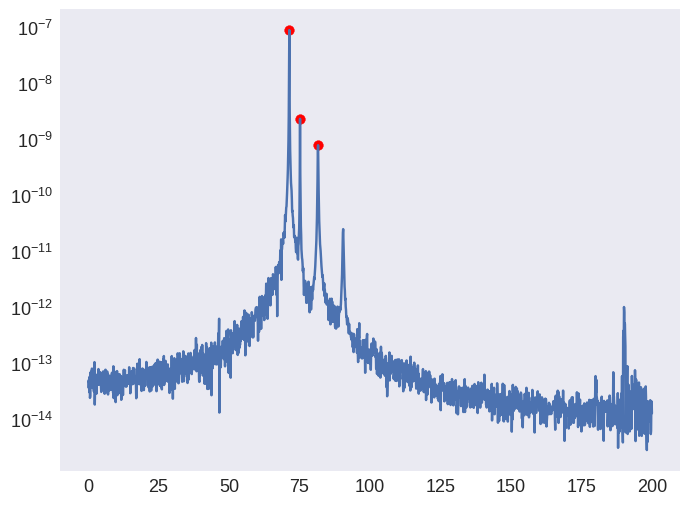

In [35]:
import matplotlib.pyplot as plt
plt.plot(processor.freq[1:,]/1e9, processor.power_ave[1:,2])
plt.scatter(processor.freq[peaks]/1e9, processor.power_ave[peaks, 2], color='red', label='Peaks') 
plt.yscale('log')

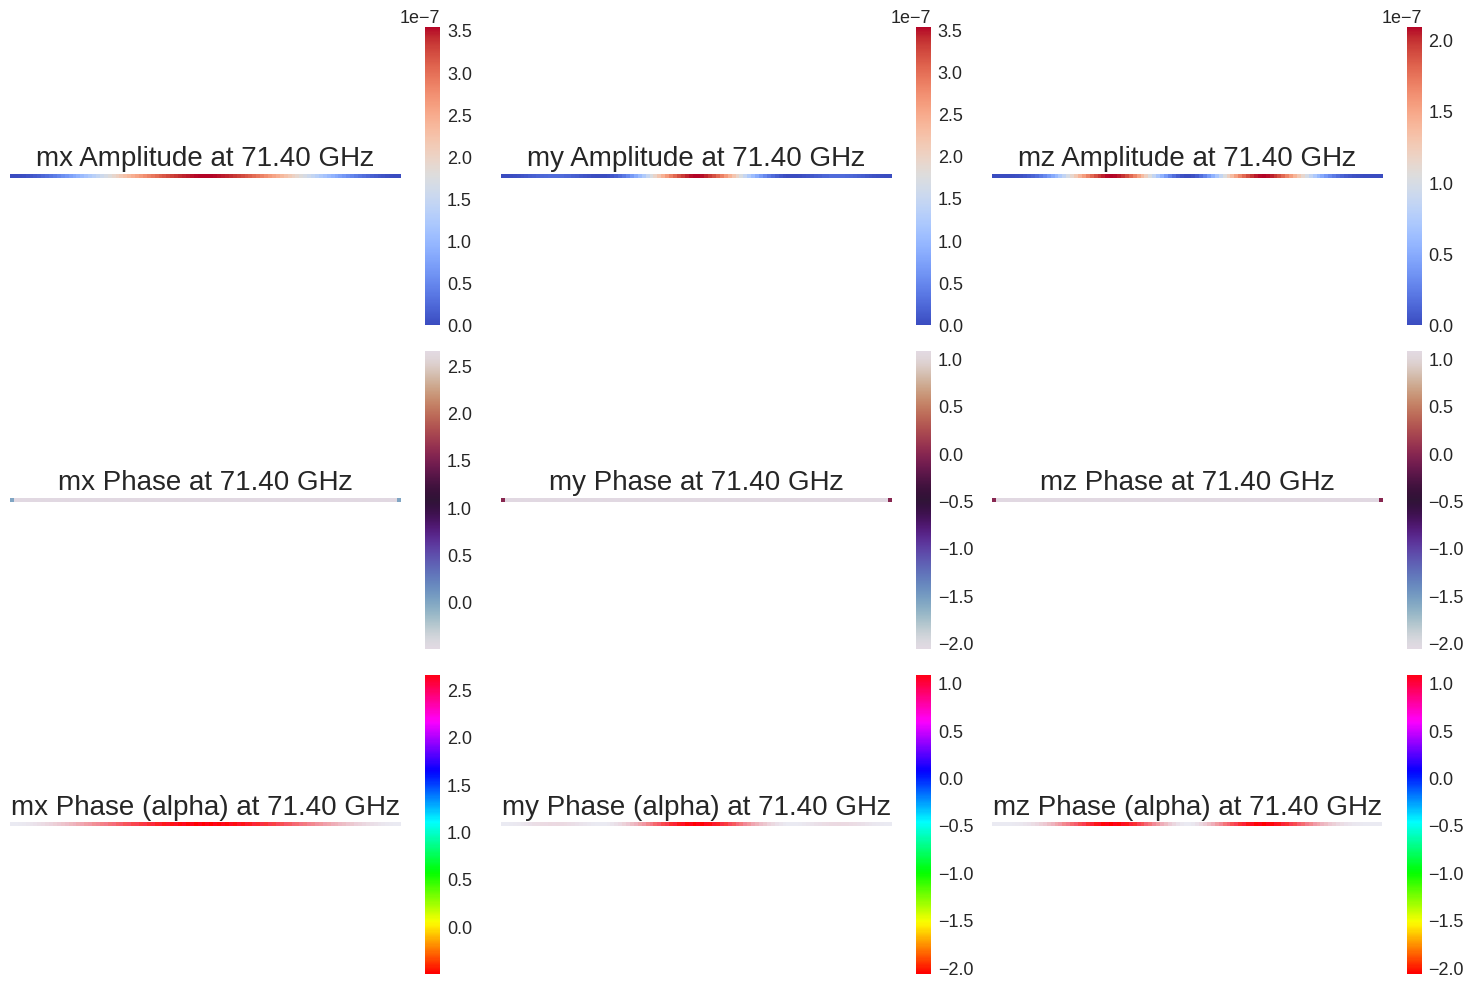

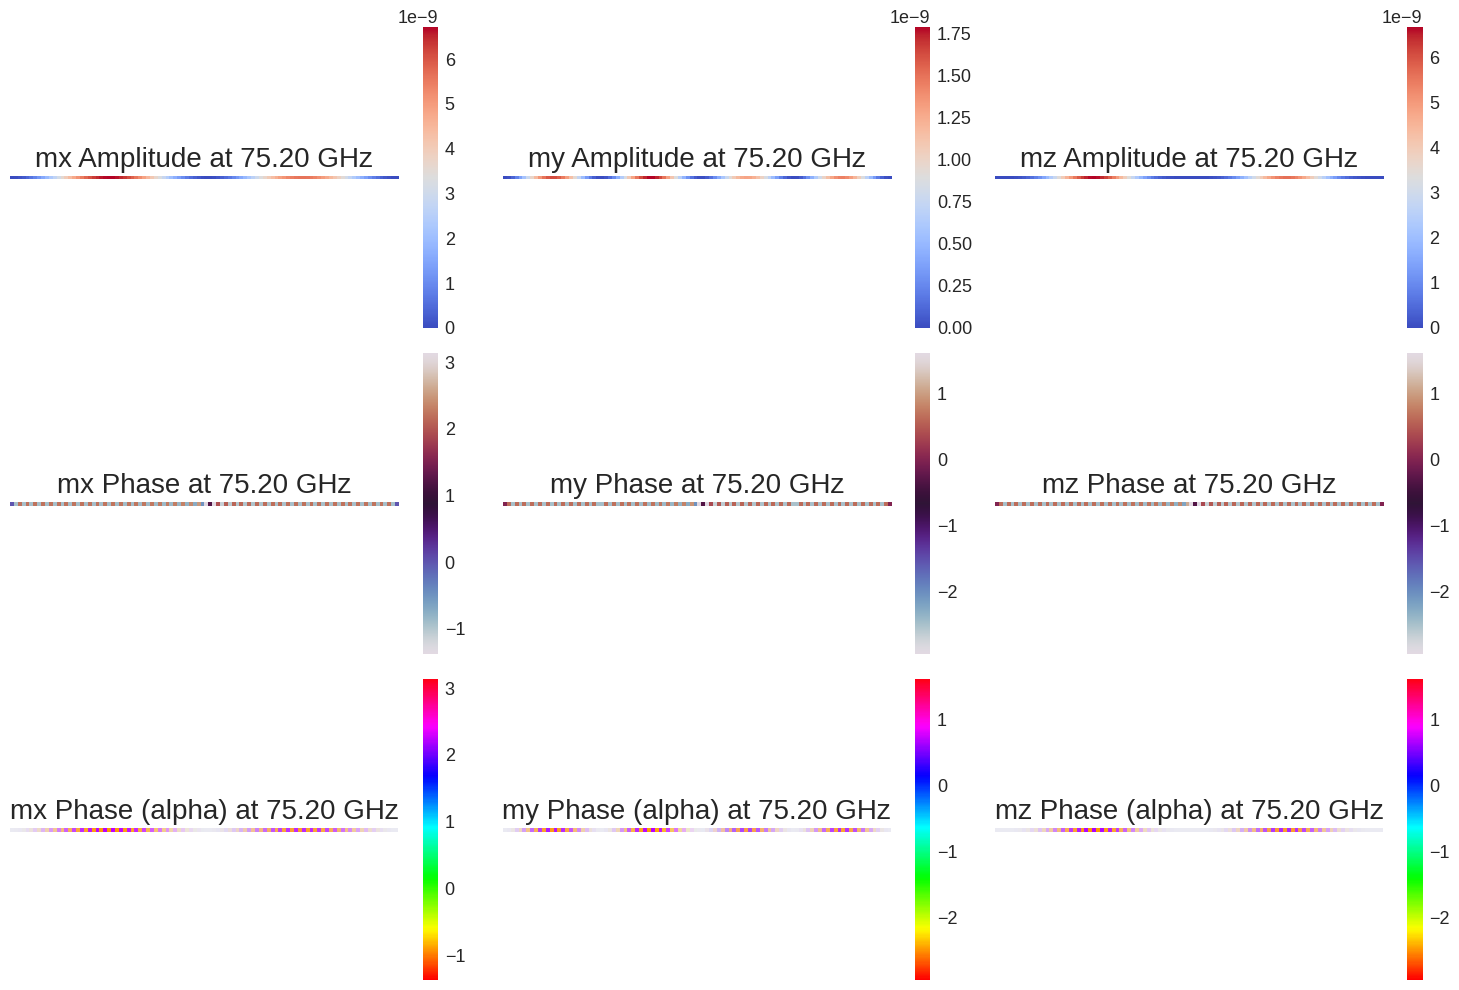

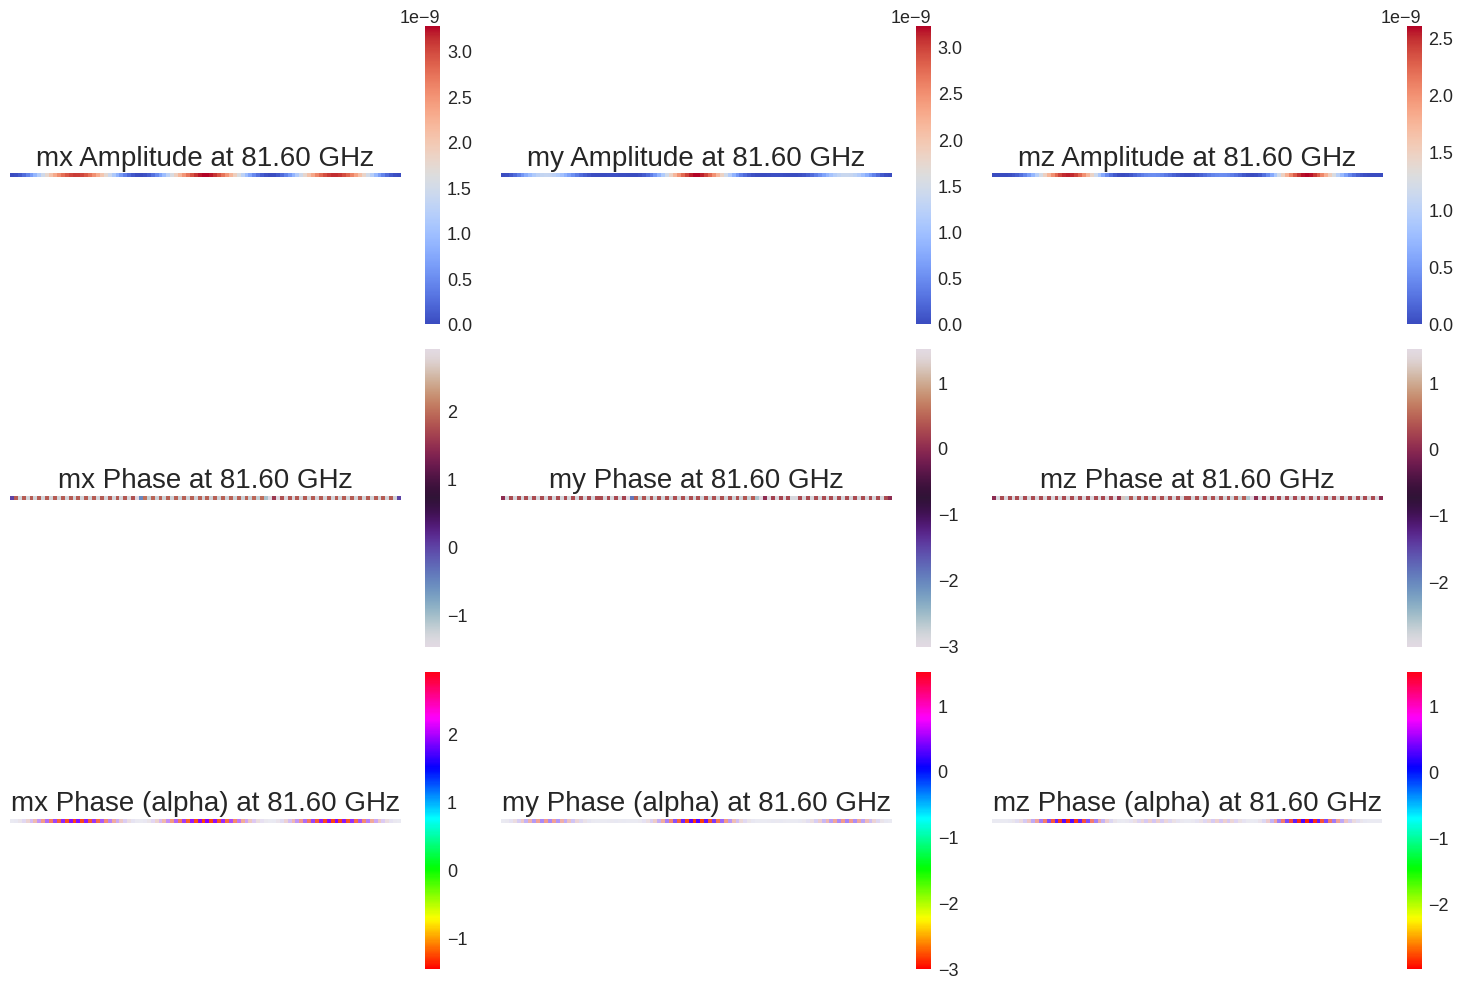

In [36]:
processor.plot_peaks() 

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
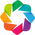

Invoked as load_subset(np.float64(2.5e-12), np.float64(5e-10))
Invoked as dynamic_operation(np.float64(2.5e-12), np.float64(5e-10))


ValueError: cannot convert float NaN to integer

:DynamicMap   [t,z]

In [37]:
processor.inverse_fft(peak_index=-1)